# Exp8. News Summarization

## 1. module import & data load

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플 수 : ', len(data))
data.sample(10)

전체 샘플 수 :  98401


,headlines,text
76628,GST Council recommends luxury car cess hike fr...,The GST Council has recommended the government...
73853,OBC creamy layer bar raised from Ã¢ÂÂ¹6 lakh ...,Union Finance Minister Arun Jaitley on Wednesd...
50445,Man dies of heart attack while playing cricket...,A 25-year-old man died of a heart attack while...
87783,World's largest aircraft completes test flight,"Airlander 10, the largest aircraft in the worl..."
74207,US embassy in Russia suspends issue of nonimmi...,The US embassy in Russia has indefinitely susp...
61065,Christians in China swap Jesus posters with Pr...,Hundreds of Christians in China's Yugan county...
55681,NASA studying human body in space for future M...,NASA is seeking proposals for research that co...
62488,Flyer caught hiding gold worth Ã¢ÂÂ¹30 lakh i...,A 46-year-old passenger was caught allegedly h...
94077,Brock Lesnar tops Forbes' highest paid WWE wre...,"WWE's wrestler Brock Lesnar, who earned over Ã..."
24367,Railways suffered Ã¢ÂÂ¹90L loss in Mumbai bri...,The railways suffered a loss of around Ã¢ÂÂ¹9...


## 2. data preprocessing
### (1) 결측치 및 중복 데이터 제거

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 : ', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 : ', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 :  98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 :  98280


- text가 달라도 headlines는 동일할 수 있기 때문에 text 자체가 중복이 된 샘플만 제거해야 된다. 

In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  98360


In [6]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### (2) 텍스트 정규화와 불용어 제거
`it'll`, `it will`과 같은 표현들을 하나로 통일시켜주는 방법론을 텍스트 정규화(text normalization)라고 한다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# 전처리 전후 결과 확인을 위해 임의의 text와 headlines 만들어 함수 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text : ", preprocess_sentence(temp_text))
print("headlines : ", preprocess_sentence(temp_headlines, False))

text :  everything bought great infact ordered twice third ordered wasfor mother father
headlines :  great way to start the day


In [10]:
clean_text = []
# 전체 Text 데어터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
# 전처리 후 출력
print("text 전처리 후 결과 : ", clean_text[:5])

text 전처리 후 결과 :  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insu

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    
print("headlines 전처리 후 결과 : ", clean_headlines[:5])

headlines 전처리 후 결과 :  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
# 데이터들을 데이터프레임에 저장, empty 값이 있으면 Null 값으로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [13]:
# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### (3) 샘플 최대 길이 설정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


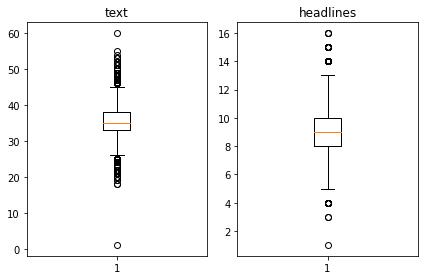

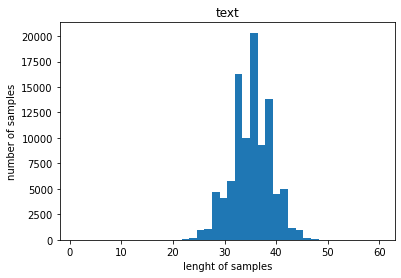

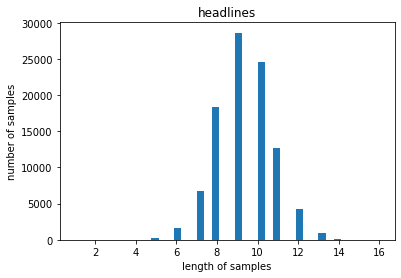

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# text 최대 길이랑 headlines 최대 길이 임의지정
text_max_len = 40
headlines_max_len = 10

- 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 된다.   
훈련 데이터와 샘플의 길이를 입력하면, 데이터와 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.

In [16]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율 : 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율 : 0.8162972753151687


- 각각 40과 10으로 패딩을 하게 되면 긴 샘플들은 내용이 잘리게 된다. 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하자. 

In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 : ', len(data))

전체 샘플 수 :  74102


### (4) 시작 토큰과 종료 토큰 추가
seq2seq 훈련을 위해서는 디코드의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.  
시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 명명하고 앞, 뒤로 추가해보자. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, 디코더의 출력 또는 레이블에 해당하면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target`이라고 정하자. 

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [20]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text'])  # 인코더의 입력
decoder_input = np.array(data['decoder_input'])  # 디코더의 입력
decoder_target = np.array(data['decoder_target'])  # 디코더의 레이블

In [21]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[59605 44768 32465 ... 38952 68576 62626]


In [22]:
# 정수 시퀀스를 이용해 다시 샘플 데이터의 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 8:2의 비율로 훈련 데이터와 테스트 데이터 분리
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수 : ', n_of_val)

테스트 데이터의 수 :  14820


In [24]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 : ', len(encoder_input_train))
print('훈련 레이블의 개수 : ', len(decoder_input_train))
print('테스트 데이터의 개수 : ', len(encoder_input_test))
print('테스트 레이블의 개수 : ', len(decoder_input_test))

훈련 데이터의 개수 :  59282
훈련 레이블의 개수 :  59282
테스트 데이터의 개수 :  14820
테스트 레이블의 개수 :  14820


### (5) 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔줘야 한다. 이를 위해서 각 단어에 고유한 정수를 맵핑하는 작업이 필요한데, 이를 **단어 집합(vocabulary)**을 만든다고 표현한다. Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [25]:
src_tokenizer = Tokenizer()  # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)  # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 :  61426
등장 빈도가 6번 이하인 희귀 단어의 수: 42156
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19270
단어 집합에서 희귀 단어의 비율: 68.62891935011233
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.201467525999735


등장빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다.  
위에서 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 19000으로 제한해보자. 

In [27]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[12188, 124, 2449, 22, 195, 1651, 1472, 18, 1101, 160, 708, 1917, 18, 4948, 30, 101, 3135, 10025, 1019, 2449, 2763, 6996, 14395, 1, 6542, 195, 5008, 202], [174, 7638, 4467, 82, 1576, 762, 718, 785, 191, 507, 552, 4147, 150, 1518, 7106, 6, 4467, 5, 1, 343, 1788, 3532, 762, 718, 181, 170, 104, 191, 299, 507, 1259, 10, 1166, 1603, 2213, 3939, 785], [55, 1109, 678, 77, 129, 2981, 2514, 3258, 400, 153, 12, 5, 83, 400, 1373, 12, 403, 678, 3309, 2, 15, 261, 2, 15, 255, 3718, 2706, 165, 348, 166, 115]]


In [29]:
# headlines 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27246
등장 빈도가 5번 이하인 희귀 단어의 수: 18211
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9035
단어 집합에서 희귀 단어의 비율: 66.83916905233795
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.992184778337043


In [31]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 20, 1880, 155, 2652, 3, 307, 24, 88], [1, 3037, 4882, 365, 443, 450, 207, 402, 625, 3458], [1, 334, 2280, 322, 5, 1273, 58, 16, 62], [1, 372, 2868, 390, 6968, 301, 1425, 3, 5710], [1, 81, 3037, 787, 2006, 49, 365, 443, 136, 4, 14]]
target
decoder  [[20, 1880, 155, 2652, 3, 307, 24, 88, 2], [3037, 4882, 365, 443, 450, 207, 402, 625, 3458, 2], [334, 2280, 322, 5, 1273, 58, 16, 62, 2], [372, 2868, 390, 6968, 301, 1425, 3, 5710, 2], [81, 3037, 787, 2006, 49, 365, 443, 136, 4, 14, 2]]


- 정상적으로 정수 인코딩 작업이 끝났다. `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 2000이 넘는 숫자는 존재하지 않는다. 
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도가 낮은 단어만으로 구성되었던 샘플들은 이제 빈 샘플이 되었을 가능성이 있다. 
- 요약문에서 길이가 0이된 샘플들의 인덱스를 받아와보자.

In [32]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test라는 변수에 저장해보자. 
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 : ', len(drop_train))
print('삭제할 테스트 데이터의 개수 : ', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 :  0
삭제할 테스트 데이터의 개수 :  0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### (6) 패딩하기
- 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해야한다.  
- 아까 정해둔 최대 길이로 패딩하고, 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 맞춰준다.

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3. modeling

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로 정의, hidden state 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터다.  
- 이 파라미터는 LSTM의 용량의 크기나, 뉴런의 개수라고 이해하면 된다. 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다. 인코더의 LSTM은 총 3개의 층으로 구성해 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다.  
- LSTM은 dropout뿐 아니라 recurrent dropout까지 사용한다. 일반적인 dropout이 레이어의 weight를 랜덤으로 생략해 모델의 overfitting을 해결한다면, recurrent dropout은 레이어가 아닌 time step마다 해주는 방식으로, regularization의 효과가 있고, overfitting을 방지할 수 있다. 
> 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고 한다. 

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.  
- 하지만 LSTM의 입력을 정의할 때, `initial_state`의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층에서는 Summary의 단어장인 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 
- 따라서 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스를 사용하고 있다.  
- 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq다.  
- 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있는데, 그게 바로 어텐션 메커니즘이다!

### (1) 어텐션 메커니즘
Tensorflow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 살펴보자. 

In [37]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4. Training

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 135s 547ms/step - loss: 6.3076 - val_loss: 5.8745
Epoch 2/50
232/232 [==============================] - 126s 543ms/step - loss: 5.7669 - val_loss: 5.5379
Epoch 3/50
232/232 [==============================] - 125s 538ms/step - loss: 5.4339 - val_loss: 5.2784
Epoch 4/50
232/232 [==============================] - 125s 539ms/step - loss: 5.1653 - val_loss: 5.0748
Epoch 5/50
232/232 [==============================] - 125s 537ms/step - loss: 4.9271 - val_loss: 4.9157
Epoch 6/50
232/232 [==============================] - 124s 534ms/step - loss: 4.7288 - val_loss: 4.7676
Epoch 7/50
232/232 [==============================] - 124s 534ms/step - loss: 4.5586 - val_loss: 4.6706
Epoch 8/50
232/232 [==============================] - 124s 537ms/step - loss: 4.4082 - val_loss: 4.5783
Epoch 9/50
232/232 [==============================] - 125s 537ms/step - loss: 4.2732 - val_loss: 4.5142
Epoch 10/50
232/232 [==============================] - 124s 533m

- 조기 종료를 뜻하는 `EarlyStopping`은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다. 위 코드에서는 val_loss를 관찰하다가, 줄어들지 않고 증가하는 현상이 2회 관측되면 학습을 멈추도록 설정되어 있다. 

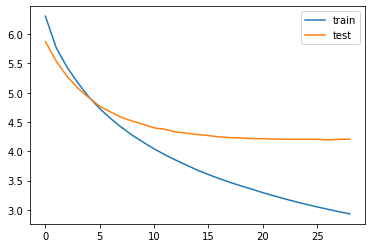

In [39]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.  
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.  
그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이 때는 인코더 모델과 디코더 모델을 분리해서 설계한다. 

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트
        e_h, e_c = h, c

    return decoded_sentence

## 4. model test (추상적 요약)

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cambridge university considering scrap written exams allow laptops replace pen paper due increasing students handwriting academics said students losing ability write hand reliance laptops lectures elsewhere difficult harder harder read scripts said lecturer 
실제 요약 : cambridge plans to scrap written exams over bad handwriting 
예측 요약 :  cbse class schools to be held in cbse quarter


원문 : google workers slammed software engineer anti diversity page memorandum written went viral company document attacked google policies foster diverse workplace according reports argued women face discrimination workplace inherent psychological differences men women 
실제 요약 : google employee slammed over anti diversity page memo 
예측 요약 :  google apologises for google firing on google memo


원문 : reacting messaging service whatsapp outage experienced new year user tweeted whatsapp aadhaar link karna another user tweeted whatsapp cannot remember send sms user also tweeted single whatsapp even notice 
실제 

## 5. Summa (추출적 요약)
- text(str) : 요약할 텍스트
- ratio(float, optional) : 요약문에서 원본에서 선택되는 문장 비율, 0~1 값
- words(int or None, optional) : 출력에 포함할 단어 수
- split(bool, optional) : True면 문장 list / False면 join된 문자열 반환

In [46]:
import requests
from summa.summarizer import summarize

In [47]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text = data['text']
print(text[:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1495    India head coach Ravi Shastri has said that he...
1496    Italian tennis player Andreas Seppi ensured hi...
1497    World number three Roger Federer was stopped b...
1498    A cutout of TMC chief and West Bengal CM Mamat...
1499    A Delhi court on Saturday pulled up Delhi Poli...
Name: text, Length: 1500, dtype: object


In [48]:
for _ in range(15):
    random_n = np.random.randint(len(text))
    print("\ntext : {}\n".format(text[random_n]))
    print("\nheadlines : {}\n".format(summarize(text[random_n], ratio=0.5)))
    print("--------------------------------------------------------------------------------------------------------")


text : The wing of an Air India plane with 179 on board went inside a building after the plane struck the building at Stockholm's Arlanda airport. The passengers could disembark from the plane on a mobile staircase and thereafter enter the terminal, said police. According to airport operator Swedavia's website, the flight had originated in New Delhi.


headlines : The wing of an Air India plane with 179 on board went inside a building after the plane struck the building at Stockholm's Arlanda airport.

--------------------------------------------------------------------------------------------------------

text : Ayushmann Khurrana revealed a gay casting director once told him, "I want to see your c*ck. Can I just feel you?" Ayushmann said, "I was like, 'Kya baat kar rahe ho yaar? Are you serious?' I said no." Ayushmann added he was told he had to do these things and was questioned on how he would survive in the industry.


headlines : Are you serious?' I said no." Ayushmann added he 

## 6. 간단한 비교분석 및 회고
- 추상적 요약 모델의 경우 텍스트를 여러 단계에 거쳐 전처리를 진행했기에 기대했던 것보다는 괜찮은 headline이 나왔던 것 같다. 처음에는 이상해보이는 요약문이 좀 있었지만 text의 maxlen 값과 빈도수에 따른 단어 집합의 크기를 조정하면서 학습해보니 결과가 점점 좋아졌다. (시간은 엄청 걸렸지만)
- 추출적 요약은 데이터 전처리 없이 데이터를 때려 넣었(?)음에도 불구하고 단어구, 문장을 잘 뽑아서 그런지 요약 결과가 대체로 적절한 것 같다. 약간 허무하다. 